In [3]:
import os
from pathlib import Path
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
os.chdir("../")

In [6]:
%pwd

'/Volumes/T7/Box_office_prediction_project/BoxOfficePrediction'

Necessary Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Display all the columns of the dataframe

pd.pandas.set_option('display.max_columns',None)

Data Path

In [8]:
cinema_db = pd.read_csv("artifacts/data_transform/organized_cinema.csv")
cinema_db.head()

,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,vote_average,vote_count,crew,release_month,avg_ticket_price,hero,heroine
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2787965087,162.0,"['English', 'Español']",Released,7.2,11800,James Cameron,Dec,7.50,Sam Worthington,Zoe Saldana
1,300000000,"['Adventure', 'Fantasy', 'Action']",en,139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],961000000,169.0,['English'],Released,6.9,4500,Gore Verbinski,May,6.88,Johnny Depp,Orlando Bloom
2,245000000,"['Action', 'Adventure', 'Crime']",en,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",880674609,148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,6.3,4466,Sam Mendes,Oct,8.43,Daniel Craig,Christoph Waltz
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",en,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],1084939099,165.0,['English'],Released,7.6,9106,Christopher Nolan,Jul,7.96,Christian Bale,Michael Caine
4,260000000,"['Action', 'Adventure', 'Science Fiction']",en,43.926995,['Walt Disney Pictures'],['United States of America'],284139100,132.0,['English'],Released,6.1,2124,Andrew Stanton,Mar,7.96,Taylor Kitsch,Lynn Collins


Dimension of Data

In [9]:
cinema_db.shape

(4809, 17)

In thi data Analysis andf feature Engineering Phase We will explore
- Missing Values
- Extract meaningful features from the existing ones
- All the numerical Variables
- Distribution of the numerical Variables
- Categorical Variables
- Cardinality of Categorical variables
- Outliers
- relationship between dependent and independent features

# Missing Values

## Missing Values with nan

In [10]:
# Here we will check the percentage of nan values present in each feature
nan_features = [feature for feature in cinema_db.columns if cinema_db[feature].isnull().sum()>1]

# percentage of missing values for each feature

for feature in nan_features:
    print(feature, " has ", cinema_db[feature].isnull().sum()," missing Values")

runtime  has  2  missing Values
crew  has  30  missing Values
hero  has  53  missing Values
heroine  has  53  missing Values


#### Let us Understand relationship between missing values and revenue

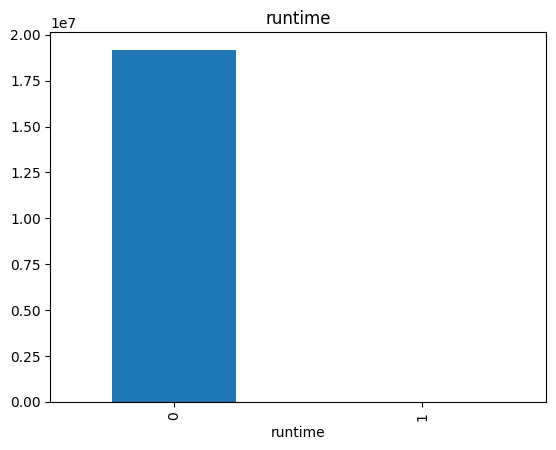

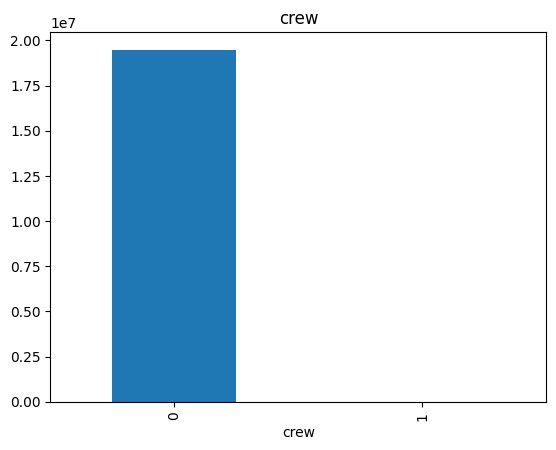

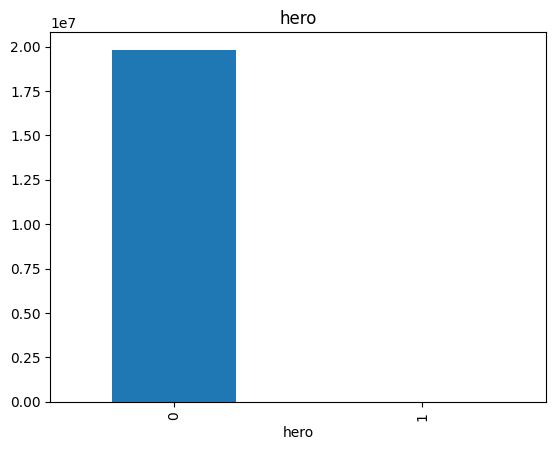

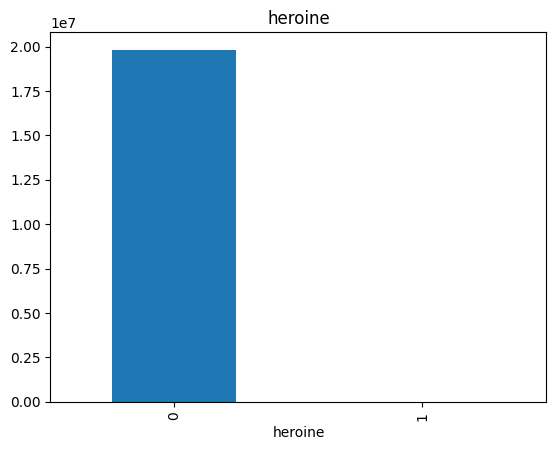

In [11]:
for feature in nan_features:
    data = cinema_db.copy()
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)

    # let us calculate the mean revenue where the observation is mssing or present
    data.groupby(feature)['revenue'].median().plot.bar()
    plt.title(feature)
    plt.show()

## Inference

- Every instance with missing value with 'NaN' has no impact on revenue so, we can remove these entries

## Missing Values with zeroes

In [12]:
zero_features = [feature for feature in cinema_db if (cinema_db[feature]==0).sum()>1]

for feature in zero_features:
    print(feature, " has ", (cinema_db[feature]==0).sum()," zero values")

budget  has  1039  zero values
revenue  has  1430  zero values
runtime  has  35  zero values
vote_average  has  63  zero values
vote_count  has  62  zero values


#### Let us Understand relationship between zero values and revenue

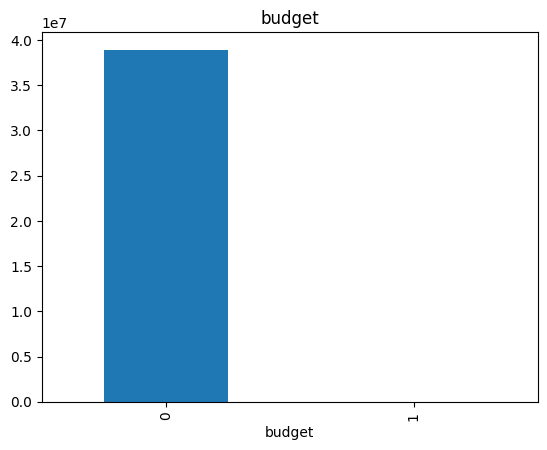

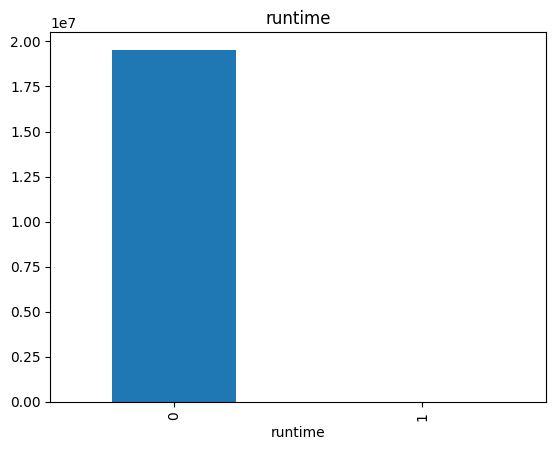

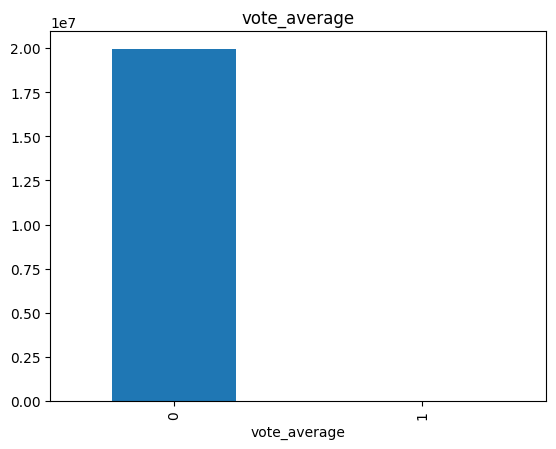

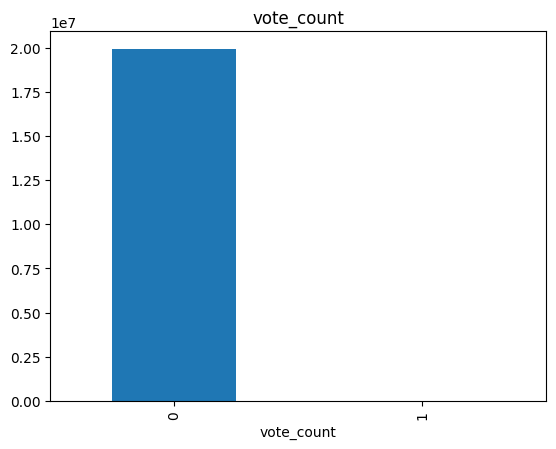

In [13]:
zero_features.remove('revenue')

for feature in zero_features:
    data = cinema_db.copy()
    # let's make a variable that indicates 1 if the observation was having zero or zero otherwise
    data[feature] = np.where(data[feature]==0, 1, 0)

    # let us calculate the mean revenue where the observation is mssing or present
    data.groupby(feature)['revenue'].median().plot.bar()
    plt.title(feature)
    plt.show()

## Inference
- Every instance with missing value with '0' has no impact on revenue so, we can remove these entries

## Objective 1
- remove all entries with nan and zero entries as they have no impact on revenue

In [14]:
nan_features = [feature for feature in cinema_db.columns if cinema_db[feature].isnull().sum()>1]
zero_features = [feature for feature in cinema_db if (cinema_db[feature]==0).sum()>1]

cond1 = (cinema_db[nan_features].isnull()).any(axis=1)
cond2 = (cinema_db[zero_features]==0).any(axis=1)

cinema_db = cinema_db[~cond1]
cinema_db = cinema_db[~cond2]

Dimension of dataset

In [15]:
cinema_db.shape

(3223, 17)

We can see that the no.of datapoints are reduced from 4809 to 3223 

# Feature Engineering

## Weighted Rating of a Movie

- We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

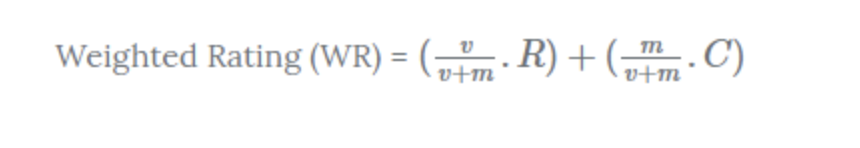

Where,
- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report

## Objective 2
- Find Weighted average of each filim from vote_average and vote_count
- And remove the 'vote_average' and 'vote_count' columns

Finding Weighted average

In [16]:
overall_mean = cinema_db['vote_average'].mean()
print("overall mean :", overall_mean)

overall mean : 6.314365497983244


In [17]:
m= cinema_db['vote_count'].quantile(0.7)
print("Minimum no.of votes that required : ",m)

Minimum no.of votes that required :  942.1999999999989


In [18]:
def weighted_rating(x, m=m, C=overall_mean):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [19]:
cinema_db['Weighted_rating'] = cinema_db.apply(weighted_rating, axis=1)

Remove 'vote_average' and 'vote_count' columns as we have the representative behaviour as 'weighted_average'

In [20]:
cinema_db.drop(['vote_count','vote_average'],axis=1, inplace=True)

In [21]:
cinema_db.head()

,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,crew,release_month,avg_ticket_price,hero,heroine,Weighted_rating
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2787965087,162.0,"['English', 'Español']",Released,James Cameron,Dec,7.50,Sam Worthington,Zoe Saldana,7.134513
1,300000000,"['Adventure', 'Fantasy', 'Action']",en,139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],961000000,169.0,['English'],Released,Gore Verbinski,May,6.88,Johnny Depp,Orlando Bloom,6.798610
2,245000000,"['Action', 'Adventure', 'Crime']",en,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",880674609,148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,Sam Mendes,Oct,8.43,Daniel Craig,Christoph Waltz,6.302503
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",en,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],1084939099,165.0,['English'],Released,Christopher Nolan,Jul,7.96,Christian Bale,Michael Caine,7.479449
4,260000000,"['Action', 'Adventure', 'Science Fiction']",en,43.926995,['Walt Disney Pictures'],['United States of America'],284139100,132.0,['English'],Released,Andrew Stanton,Mar,7.96,Taylor Kitsch,Lynn Collins,6.165871


## Number of tickets sold 

- In this dataset we have observed that there are filims which between 1916 and 2017.


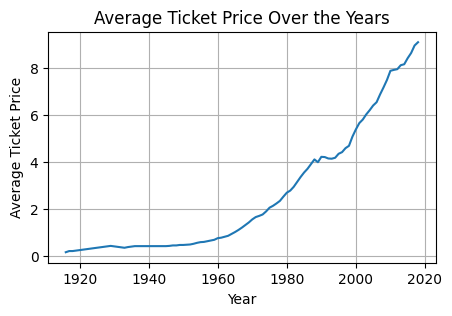

- There is high variation in ticket prices over time
- When predicting footfall over revenue can be more meaningful which could be more precise irrespective of time 
- After we predict footfall, we can estimete revenue by:
    - revenue = footfall * Current ticket price

## Objective 3

-  Extract footfall of each filim based on revenue and ticket_price
-  remove revenue and ticket_price

In [22]:
cinema_db['footfall'] = cinema_db['revenue']//cinema_db['avg_ticket_price']
cinema_db['footfall'].head()


0    371728678.0
1    139680232.0
2    104469111.0
3    136298881.0
4     35695866.0
Name: footfall, dtype: float64

In [23]:
cinema_db.drop(['revenue','avg_ticket_price'],axis=1,inplace=True)

cinema_db.head()

,budget,genres,original_language,popularity,production_companies,production_countries,runtime,spoken_languages,status,crew,release_month,hero,heroine,Weighted_rating,footfall
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",162.0,"['English', 'Español']",Released,James Cameron,Dec,Sam Worthington,Zoe Saldana,7.134513,371728678.0
1,300000000,"['Adventure', 'Fantasy', 'Action']",en,139.082615,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],169.0,['English'],Released,Gore Verbinski,May,Johnny Depp,Orlando Bloom,6.798610,139680232.0
2,245000000,"['Action', 'Adventure', 'Crime']",en,107.376788,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']",148.0,"['Français', 'English', 'Español', 'Italiano',...",Released,Sam Mendes,Oct,Daniel Craig,Christoph Waltz,6.302503,104469111.0
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",en,112.312950,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],165.0,['English'],Released,Christopher Nolan,Jul,Christian Bale,Michael Caine,7.479449,136298881.0
4,260000000,"['Action', 'Adventure', 'Science Fiction']",en,43.926995,['Walt Disney Pictures'],['United States of America'],132.0,['English'],Released,Andrew Stanton,Mar,Taylor Kitsch,Lynn Collins,6.165871,35695866.0


## Categorical Features

## Types of Categorical Features
- list type
- normal

In [24]:
categorical_features = [feature for feature in cinema_db.columns if cinema_db[feature].dtypes=='O']
cinema_db[categorical_features].head()

,genres,original_language,production_companies,production_countries,spoken_languages,status,crew,release_month,hero,heroine
0,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",en,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']","['English', 'Español']",Released,James Cameron,Dec,Sam Worthington,Zoe Saldana
1,"['Adventure', 'Fantasy', 'Action']",en,"['Walt Disney Pictures', 'Jerry Bruckheimer Fi...",['United States of America'],['English'],Released,Gore Verbinski,May,Johnny Depp,Orlando Bloom
2,"['Action', 'Adventure', 'Crime']",en,"['Columbia Pictures', 'Danjaq', 'B24']","['United Kingdom', 'United States of America']","['Français', 'English', 'Español', 'Italiano',...",Released,Sam Mendes,Oct,Daniel Craig,Christoph Waltz
3,"['Action', 'Crime', 'Drama', 'Thriller']",en,"['Legendary Pictures', 'Warner Bros.', 'DC Ent...",['United States of America'],['English'],Released,Christopher Nolan,Jul,Christian Bale,Michael Caine
4,"['Action', 'Adventure', 'Science Fiction']",en,['Walt Disney Pictures'],['United States of America'],['English'],Released,Andrew Stanton,Mar,Taylor Kitsch,Lynn Collins


Some categorical features have multiple entries in it(type) and some have single entry

## Handling list Type Categorical Features

In [25]:
import ast

In [26]:
## here even the list type columns have string repesentation in the dataframe so we need to convert them to list representation for analysis

dataset = cinema_db.copy()

list_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
for col in list_columns:
    dataset[col] = dataset[col].apply(ast.literal_eval)

In [27]:
# Calculate the number of unique entries in columns with lists

unique_entries_count = {}
for col in list_columns:
    unique_entries_count[col] = len(set(entry for sublist in dataset[col] for entry in sublist))

print("Number of unique entries in columns with lists:")
for col, count in unique_entries_count.items():
    print(f"{col}: {count}")

Number of unique entries in columns with lists:
genres: 19
production_companies: 3557
production_countries: 61
spoken_languages: 58


Understanding distribution of each unique feature

In [28]:
from collections import Counter

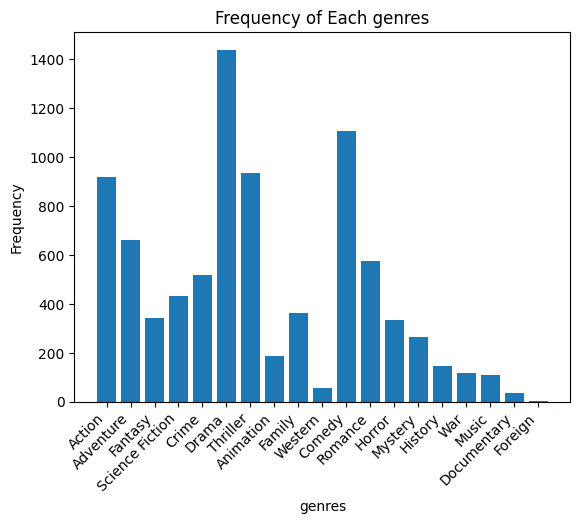

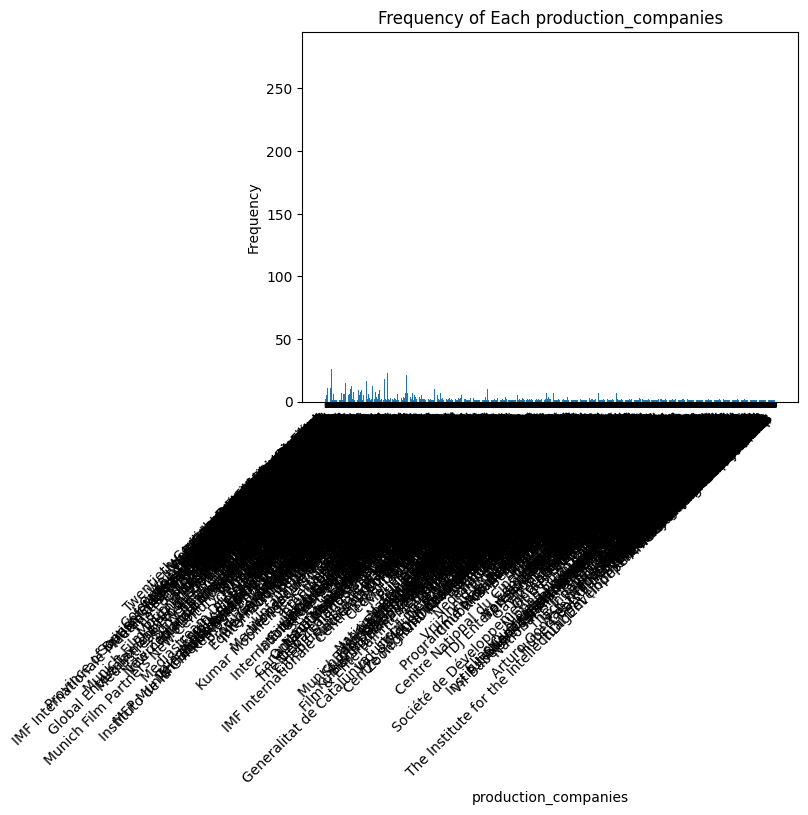

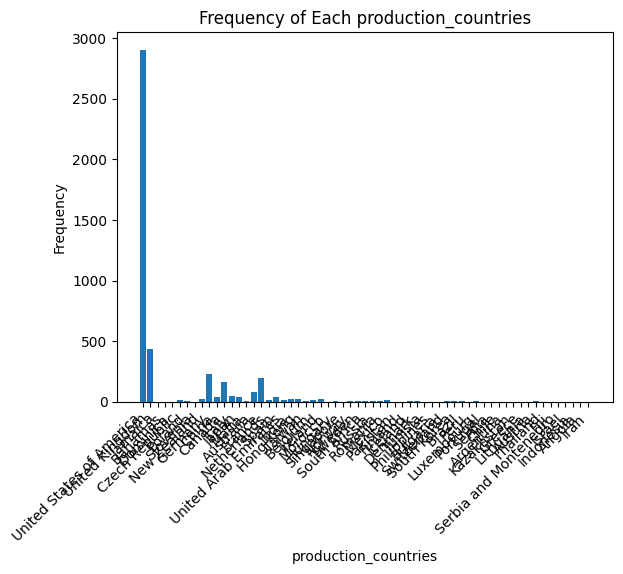

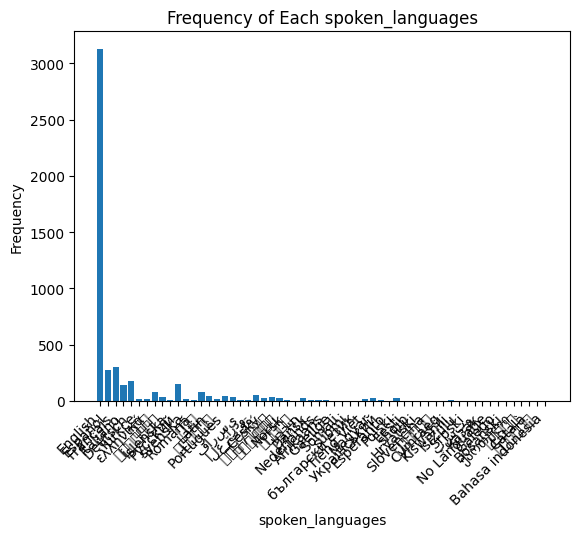

In [29]:
for feature in list_columns:
    # Flatten the lists in each feature column
    flat_features = [entry for sublist in dataset[feature] for entry in sublist]

    # Count the frequency of each unique entry
    feature_counts = Counter(flat_features)

    # Plot the frequencies
    plt.bar(feature_counts.keys(), feature_counts.values())
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title('Frequency of Each {}'.format(feature))
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.show()

## Inference
- There are 19 genres each genre having significant distribution in the dataset
- There 3557 production companies each not having atleast 50 filims so they are not useful for training. (must remove this column)
- There are 61 production countries but majority of them were skewed to United states (so it is united states or other)
- there are 58 spoken languages but majority of them were skewed to en(english) (so it is english or other)

## Objective 4
- remove production companies column
- change entries of porduction_countries as US or other
- change entries of spoken_languages to english or other
- remove original_language as we have the data of spoken_languages similar to it.

drop production_companies

In [30]:
cinema_db.drop(['production_companies'],axis=1,inplace=True)

In [31]:
import ast

Change entries in production_countries

In [32]:
def update_countries(list):
    if 'United States of America' in list:
        return 'US'
    else:
        return 'other'

In [33]:
cinema_db['production_countries'] = cinema_db['production_countries'].apply(update_countries)


In [34]:
cinema_db['production_countries'].value_counts()

production_countries
US       2903
other     320
Name: count, dtype: int64

change entries in spoken_languages

In [35]:
def update_language(list):
    if 'English' in list:
        return 'en'
    else:
        return 'other'

In [36]:
cinema_db['spoken_languages'] =  cinema_db['spoken_languages'].apply(update_language)


In [37]:
cinema_db['spoken_languages'].value_counts()

spoken_languages
en       3129
other      94
Name: count, dtype: int64

drop origial_language

In [38]:
cinema_db.drop(['original_language'],axis=1,inplace=True)

In [39]:
cinema_db.head()

,budget,genres,popularity,production_countries,runtime,spoken_languages,status,crew,release_month,hero,heroine,Weighted_rating,footfall
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",150.437577,US,162.0,en,Released,James Cameron,Dec,Sam Worthington,Zoe Saldana,7.134513,371728678.0
1,300000000,"['Adventure', 'Fantasy', 'Action']",139.082615,US,169.0,en,Released,Gore Verbinski,May,Johnny Depp,Orlando Bloom,6.798610,139680232.0
2,245000000,"['Action', 'Adventure', 'Crime']",107.376788,US,148.0,en,Released,Sam Mendes,Oct,Daniel Craig,Christoph Waltz,6.302503,104469111.0
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",112.312950,US,165.0,en,Released,Christopher Nolan,Jul,Christian Bale,Michael Caine,7.479449,136298881.0
4,260000000,"['Action', 'Adventure', 'Science Fiction']",43.926995,US,132.0,en,Released,Andrew Stanton,Mar,Taylor Kitsch,Lynn Collins,6.165871,35695866.0


## Normal Categorical Features

In [40]:
normal_features = [feature for feature in cinema_db.columns if cinema_db[feature].dtypes=='O' and feature!='genres']

In [41]:
for feature in normal_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(cinema_db[feature].unique())))

The feature is production_countries and number of categories are 2
The feature is spoken_languages and number of categories are 2
The feature is status and number of categories are 2
The feature is crew and number of categories are 1439
The feature is release_month and number of categories are 12
The feature is hero and number of categories are 1296
The feature is heroine and number of categories are 1802


Since crew, hero, heroine are have many unique values They have to be treated seperately

In [42]:
speacial_features = ['crew','hero','heroine']

In [43]:
normal_features = [feature for feature in normal_features if feature not in speacial_features]
normal_features

['production_countries', 'spoken_languages', 'status', 'release_month']

Find out the relationship between categorical variable and dependent feature footfalls

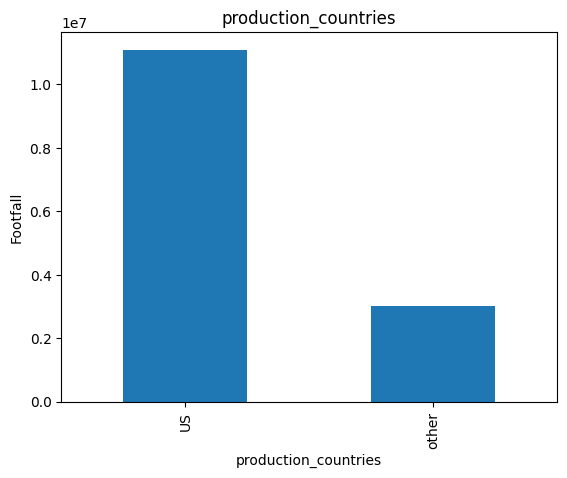

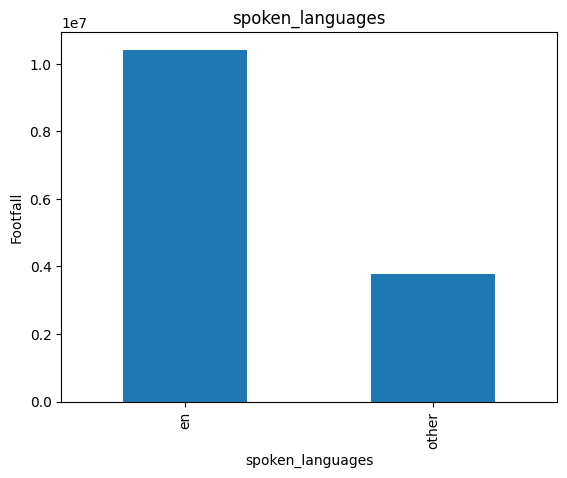

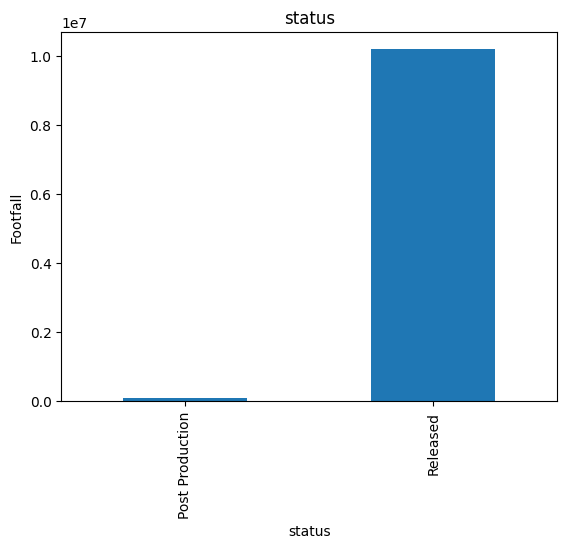

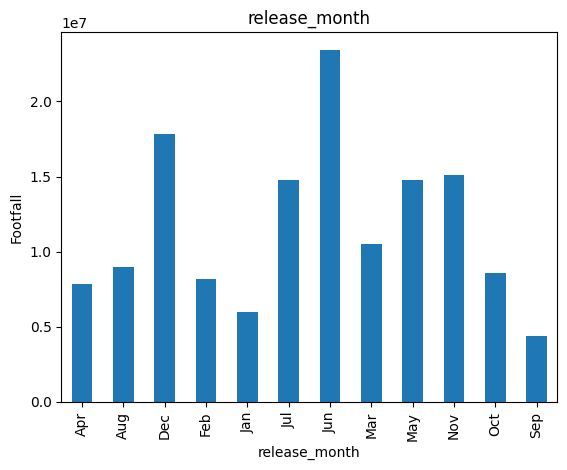

In [44]:
for feature in normal_features:
    data = cinema_db.copy()
    data.groupby(feature)['footfall'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Footfall')
    plt.title(feature)
    plt.show()

## Inference
- the impact of movies in post production stage is very minimal so we have to remove such entries
- the impact of release month is significant for every mont

## Objective 5
- Remove entries belong to post production stage
- then remove the status column as there will be only one category left

In [45]:
condition = cinema_db['status']!='Released'
cinema_db = cinema_db[~condition]

In [46]:
cinema_db.drop(['status'],axis=1,inplace=True)

In [47]:
cinema_db.head()

,budget,genres,popularity,production_countries,runtime,spoken_languages,crew,release_month,hero,heroine,Weighted_rating,footfall
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",150.437577,US,162.0,en,James Cameron,Dec,Sam Worthington,Zoe Saldana,7.134513,371728678.0
1,300000000,"['Adventure', 'Fantasy', 'Action']",139.082615,US,169.0,en,Gore Verbinski,May,Johnny Depp,Orlando Bloom,6.798610,139680232.0
2,245000000,"['Action', 'Adventure', 'Crime']",107.376788,US,148.0,en,Sam Mendes,Oct,Daniel Craig,Christoph Waltz,6.302503,104469111.0
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",112.312950,US,165.0,en,Christopher Nolan,Jul,Christian Bale,Michael Caine,7.479449,136298881.0
4,260000000,"['Action', 'Adventure', 'Science Fiction']",43.926995,US,132.0,en,Andrew Stanton,Mar,Taylor Kitsch,Lynn Collins,6.165871,35695866.0


## Special Categorical Features
- crew, hero, heroine
- Have many unique values so they cannot be handled by using common techniques like one-hot-encoding, label-encoding, frequency-encoding etc..
- They have to be handled specially

In [48]:
speacial_features = ['crew','hero','heroine']

- As we the cast, crew working on the project are the major aspects in the filims success, we have to consider their past records and analyse their credibility to pull the audience. 

- cannot be handled by using common techniques like one-hot-encoding, label-encoding, frequency-encoding etc..

- from the given dataframe popularity, weighted_rating are the features determined after the release and cannot be asked from the user for predicting revenue. So we will use these features to assign scores to the special features ultematly determinig their capability

- for that let us consider the features that are related to the footfall

In [49]:
import seaborn as sns

In [50]:
num_features = [feature for feature in cinema_db.columns if cinema_db[feature].dtypes!='O']

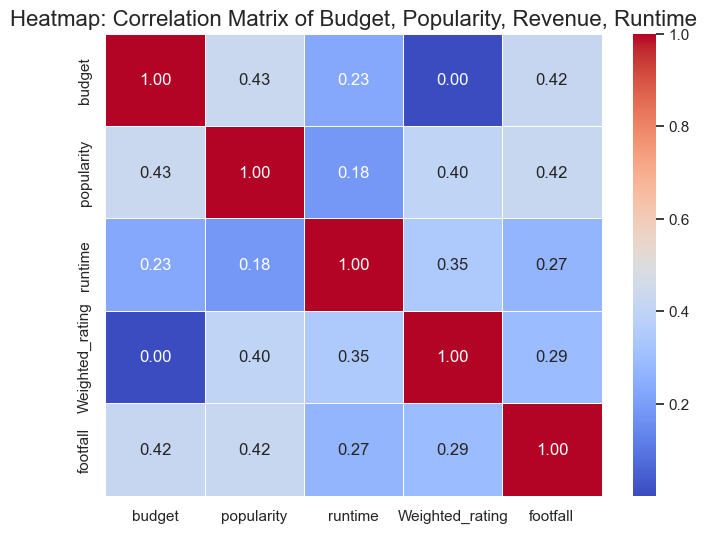

In [51]:
corr_matrix = cinema_db[num_features].corr()

sns.set_theme()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap: Correlation Matrix of Budget, Popularity, Revenue, Runtime', fontsize=16)
plt.show()

We can observe that footfall is highly related to popularity and less related to weighted_rating

so we consider 'score = 0.7*popularity + 0.3*weighted_rating'

## Objective 6

- Scores to crew, hero, heroine
- apply log normal distribution if it is skewed
- save the tables for further retrival
- remove popularity and weighted_ratig columns as we have extracted their prevelence and we do not take these features from user

In [52]:
def assign_score(feature, cinema_db):
    feature_data = cinema_db.groupby(feature)
    columns = [feature, 'score']

    feature_score = pd.DataFrame(columns=columns)
    for group_name, group_data in feature_data:
        popularity_score = group_data['popularity'].mean()
        weighted_rating_score = group_data['Weighted_rating'].mean()

        score = 0.7 * popularity_score + 0.3 * weighted_rating_score

        # Append a row to the DataFrame using loc
        feature_score.loc[len(feature_score)] = [group_name, score]
    
    return feature_score


### Director Score

In [53]:
director_score = assign_score('crew',cinema_db)
director_score.head()

,crew,score
0,Abel Ferrara,3.969161
1,Adam Marcus,9.025855
2,Adam McKay,23.510233
3,Adam Rapp,4.448174
4,Adam Rifkin,5.895643


In [54]:
director_row = director_score[director_score['crew']=='James Cameron']
director_score_value = director_row['score'].values[0]
print(director_score_value)
    

57.9094563788194


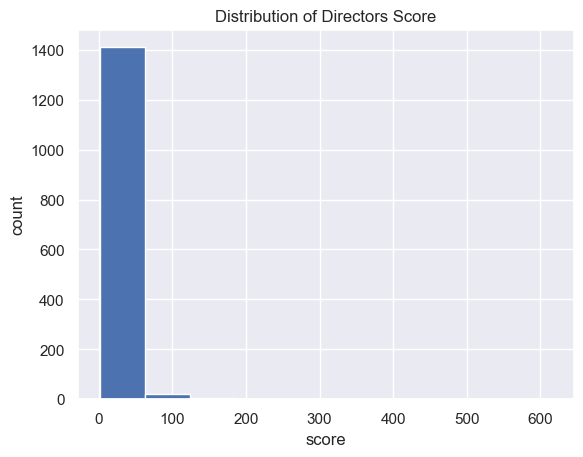

In [55]:
director_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Directors Score")
plt.show()

Since the scores are skewed, we perform log normal distribution

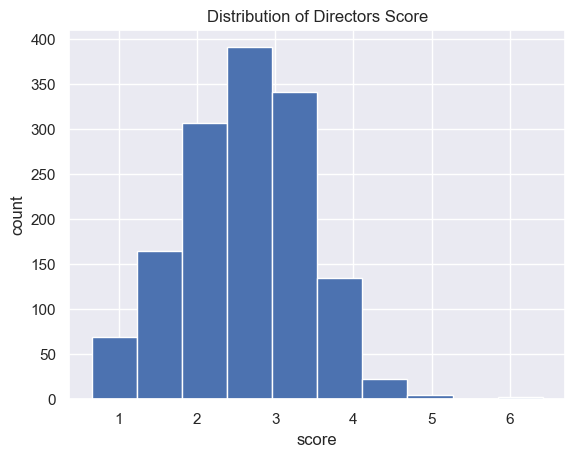

In [56]:
director_score['score'] = np.log(director_score['score'])
director_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Directors Score")
plt.show()

### hero Score

In [57]:
hero_score = assign_score('hero',cinema_db)
hero_score.head()

,hero,score
0,50 Cent,10.913789
1,Aamir Khan,5.563986
2,Aaron Eckhart,23.135329
3,Aaron Kwok,5.200370
4,Aaron Paul,40.225032


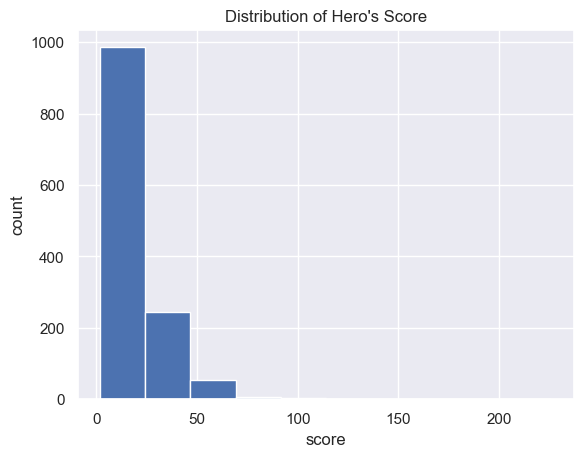

In [58]:
hero_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Hero's Score")
plt.show()

Skewed do we have to apply log normal distribution

In [59]:
hero_score['score'] = np.log(hero_score['score'])


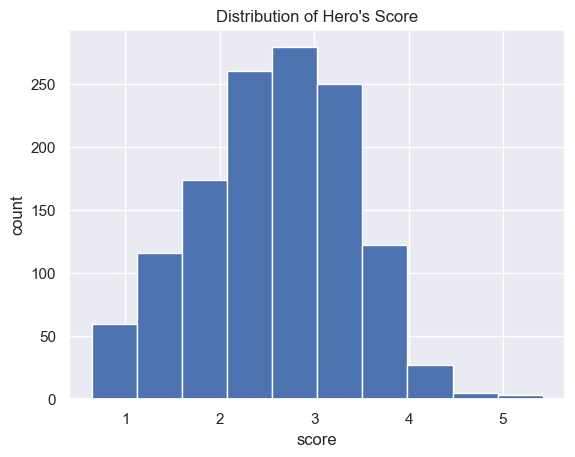

In [60]:
hero_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Hero's Score")
plt.show()

### heroine's score

In [61]:
heroine_score = assign_score('heroine',cinema_db)
heroine_score.head()

,heroine,score
0,A.J. Cook,27.978678
1,Aaliyah,12.842332
2,Aaran Thomas,6.452614
3,Aaron Eckhart,19.533405
4,Aaron Ruell,18.459606


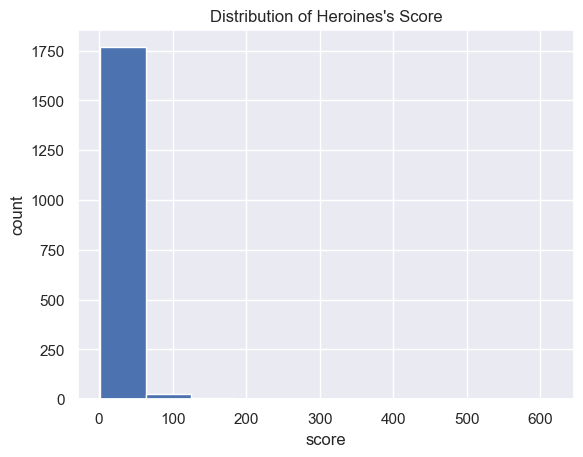

In [62]:
heroine_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Heroines's Score")
plt.show()

It is also skewed we need to apply log normal distribution

In [63]:
heroine_score['score'] = np.log(heroine_score['score'])


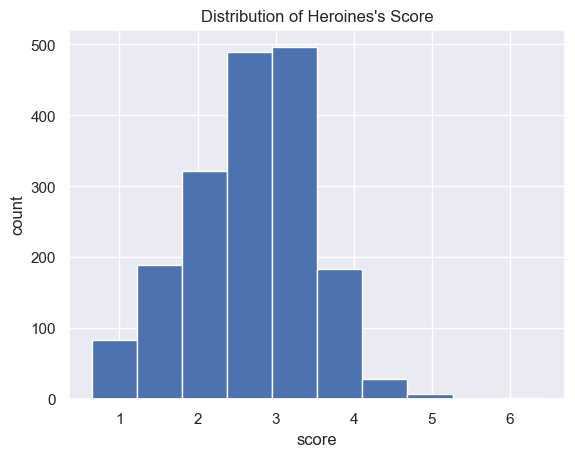

In [64]:
heroine_score['score'].hist(bins=10)
plt.xlabel('score')
plt.ylabel('count')
plt.title("Distribution of Heroines's Score")
plt.show()

### Remove popularity and weighted_rating

In [65]:
cinema_db.drop(['popularity','Weighted_rating'],axis=1,inplace=True)

# Numerical Features

In [66]:
num_features = [feature for feature in cinema_db.columns if cinema_db[feature].dtypes!='O']

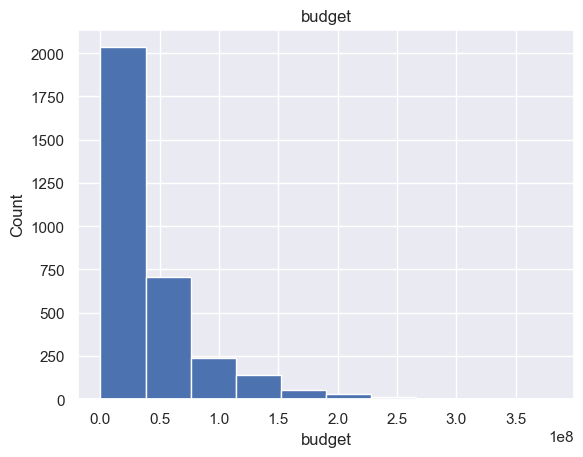

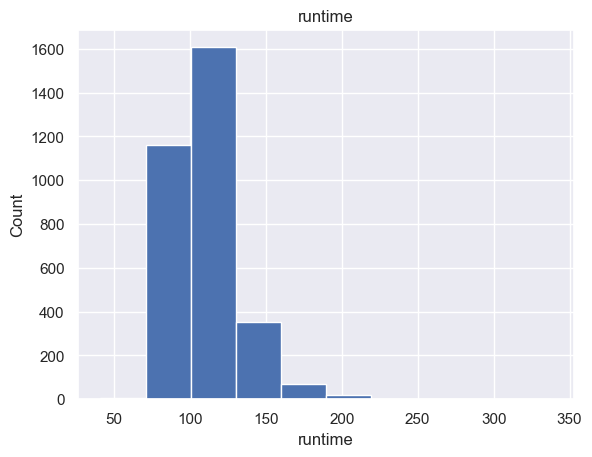

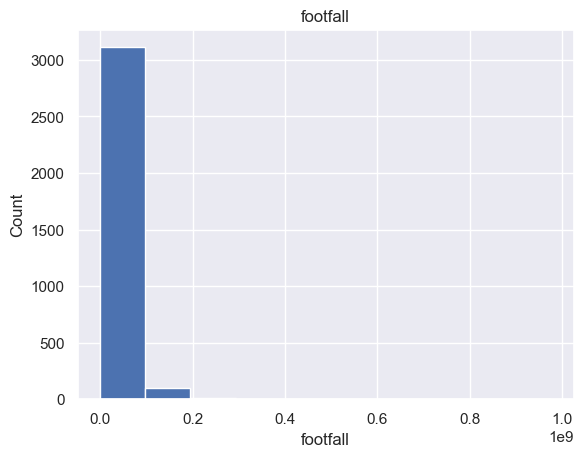

In [67]:
for feature in num_features:
    data = cinema_db.copy()
    data[feature].hist(bins=10)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

Outliers

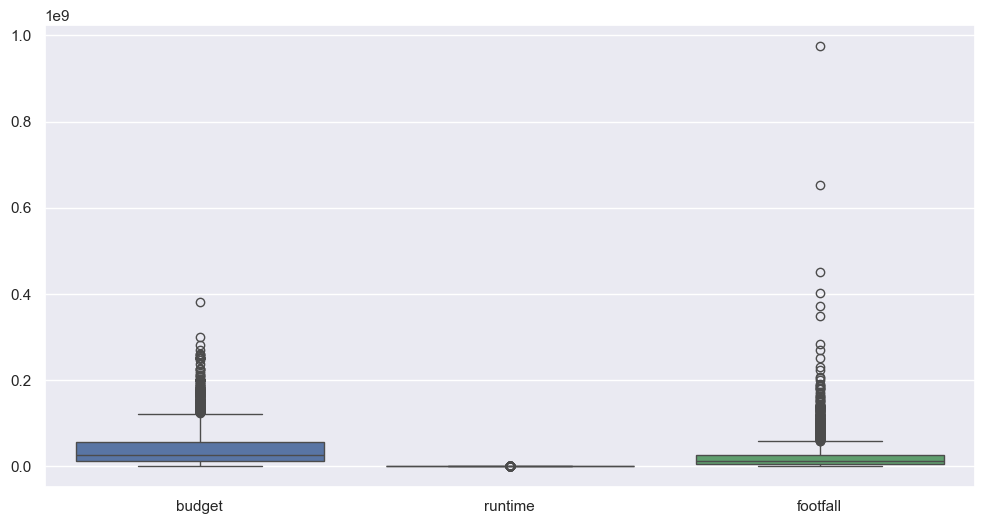

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cinema_db[num_features])
plt.show()

## Inference
- all the numerical features are skewed
- we have to apply log normal disribution to make data normally distributed and handle outliers

# After Feature Engineering

- include features that we expect from user and target variable to predict

In [69]:
cinema_db.head()

,budget,genres,production_countries,runtime,spoken_languages,crew,release_month,hero,heroine,footfall
0,237000000,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",US,162.0,en,James Cameron,Dec,Sam Worthington,Zoe Saldana,371728678.0
1,300000000,"['Adventure', 'Fantasy', 'Action']",US,169.0,en,Gore Verbinski,May,Johnny Depp,Orlando Bloom,139680232.0
2,245000000,"['Action', 'Adventure', 'Crime']",US,148.0,en,Sam Mendes,Oct,Daniel Craig,Christoph Waltz,104469111.0
3,250000000,"['Action', 'Crime', 'Drama', 'Thriller']",US,165.0,en,Christopher Nolan,Jul,Christian Bale,Michael Caine,136298881.0
4,260000000,"['Action', 'Adventure', 'Science Fiction']",US,132.0,en,Andrew Stanton,Mar,Taylor Kitsch,Lynn Collins,35695866.0


In [70]:
cinema_db.dtypes

budget                    int64
genres                   object
production_countries     object
runtime                 float64
spoken_languages         object
crew                     object
release_month            object
hero                     object
heroine                  object
footfall                float64
dtype: object

: 

# Steps to perform in the preprocessing stage later

## budget, runtime

- perform log normal distribution
- Normalize with standard Scaler

## genres
- Stacked one-hot-encoding

## production_countries, spoken_languages
- one-hot-encoding

## release_month
- Label encoding
- normalize with Standard scaler

## crew, hero, heroine
- get scores from the database
- Normalize with Standard Scaler

## footfall - target variable
- apply log normal distribution